# On-Base Percentage Linear Analysis

The purpose of this analysis is to predict a player's on-base percentage at the end of the season 2019 season based on their statistics through March and April. Having already been provided metrics from 2019, I gathered data from March/April of 2015-2018 and the On-Base Percentage at the end of those seasons to be used as the target variable. Due to the continuous nature of the features and target variable, I have decided to use a linear regression model for this analysis. Additional data was gathered from fangraphs.com.

In [1]:
# Import necessary libraries.
import pandas as pd
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import scipy.stats as stats
from scipy.stats import zscore
from matplotlib import pyplot
import warnings
warnings.filterwarnings("ignore")

To keep the rest of the notebook clean and organized I have grouped all of the functions in the block of code below. The functions below have been sourced from previous projects that I have put together. 

In [2]:
# Create a new dataframe showing the absolute value of the correlation of two features.
def high_corr(df):
    df_highcorr = df.corr().abs().stack().reset_index().sort_values(0, ascending=False)
    df_highcorr['Highly Correlated Pairs'] = list(zip(df_highcorr.level_0, df_highcorr.level_1))
    df_highcorr.set_index(['Highly Correlated Pairs'], inplace = True)
    df_highcorr.drop(columns=['level_1', 'level_0'], inplace = True)
    df_highcorr.columns = ['Correlation']
    df_highcorr.drop_duplicates(inplace=True)
    return df_highcorr[(df_highcorr.Correlation>.8) & (df_highcorr.Correlation<1)]

# Visualize the impact of a few key metrics on OBP.
def hist(X_Col):
    plt.title('Distribution')
    sns.distplot(X_Col, hist=True, kde=False, 
                 bins=int(180/5), color = 'blue',
                 hist_kws={'edgecolor':'black'})
    plt.show();
    
def lmplot(X_var, df):    
    sns.lmplot(x = X_var, y = 'Full Season OBP', data=df,
               height=3, aspect= 2,
               line_kws={'color':'black', 'linestyle':':'})
    plt.show();

#Creates a summary of the mean, min, max, standard deviation as well as the value three standards deviations from the mean.    
def describe_outliers(df):    
    print('DATA DESCRIPTION')
    print("========================================")
    describe = df.describe()

    describe.loc['+3_std'] = describe.loc['mean'] + (describe.loc['std'] * 3)
    describe.loc['-3_std'] = describe.loc['mean'] - (describe.loc['std'] * 3)
    print(describe)

#Removes outliers more than 3 standard deviations away from the mean for each listed feature    
def remove_outliers(df, features):
    print("COUNT OF OUTLIERS REMOVED")
    print("========================================")
    
    x = len(df)
    
    for feature in features:
        df[feature + '_zscore'] = np.abs(stats.zscore(df[feature]))
        y = df.loc[np.abs(df[feature + '_zscore']) > 3]
        percent = round((len(y) * 100) / x, 3)
        
        print(len(y), "outliers removed for", feature)
        
        df = df.loc[np.abs(df[feature + '_zscore']) < 3]
        
        df = df.drop([feature + '_zscore'], axis=1)
    
    return df    

def reg_summary(X_train, y_train):
    X_with_constant = sm.add_constant(X_train)
    model = sm.OLS(y_train, X_with_constant)
    results = model.fit()
    print(results.params)
    print(results.summary())
    return results    
    
def validate_reg_assumptions(X, X_train, X_test, y_train, y_test):
    product = reg_summary(X_train, y_train)
    print(product)
    
    print('RESIDUALS:')
    print("========================================")
    X_test = sm.add_constant(X_test)
    y_pred = product.predict(X_test)
    residual = y_test - y_pred

    print('Check for Normality of Residuals')
    print("========================================")
    sns.distplot(residual)
    plt.show();
    draw_qqplot(residual)
    plt.show();
    print('Residuals (Mean): ', np.mean(residual))
    print("========================================")

    print('Display the Regplot')
    print("========================================")
    draw_scatter(y_pred, residual)
    sns.regplot(y_pred, residual, color='red')
    
def draw_qqplot(residual):
    fig, ax = plt.subplots(figsize=(6,2.5))
    _, (__, ___, r) = sp.stats.probplot(residual, plot=ax, fit=True)
    
    return fig, ax
    
def draw_scatter(y_pred, residual):
    fig, ax = plt.subplots(figsize=(6,2.5))
    _ = ax.scatter(y_pred, residual, color='blue')
    
    return fig, ax

def stepwise_selection(X, y, 
                       initial_list=[], 
                       threshold_in=0.01, 
                       threshold_out = 0.05, 
                       verbose=True): 
    included = list(initial_list)
    while True:
        changed=False
        # forward step
        excluded = list(set(X.columns)-set(included))
        new_pval = pd.Series(index=excluded)
        for new_column in excluded:
            model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included+[new_column]]))).fit()
            new_pval[new_column] = model.pvalues[new_column]
        best_pval = new_pval.min()
        if best_pval < threshold_in:
            best_feature = new_pval.idxmin()
            included.append(best_feature)
            changed=True
            if verbose:
                print('Add  {:30} with p-value {:.6}'.format(best_feature, best_pval))

        # backward step
        model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included]))).fit()
        # use all coefs except intercept
        pvalues = model.pvalues.iloc[1:]
        worst_pval = pvalues.max() # null if pvalues is empty
        if worst_pval > threshold_out:
            changed=True
            worst_feature = pvalues.argmax()
            if verbose:
                print('Drop {:30} with p-value {:.6}'.format(worst_feature, worst_pval))
        if not changed:
            break
    return included

def heatmap(d):
    plt.figure(figsize=(20, 10))
    heatmap = sns.heatmap(d.corr(), vmin=-1, vmax=1, annot=True)
    heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':12}, pad=12);
    
def log_transform(df,features):
    for feature in features:
        df[feature + '_log'] = np.log(df[feature])
    return df

## Importing/Cleaning Data

A majority of the data cleaning was done using excel before importing into this workbook. However, some remains and that will be completed in this section before continuing to analysis.

In [3]:
#Import table containing statistics from 2015-2018
df = pd.read_csv('Phillies_Analysis.csv')

In [4]:
#Preview table
df.head()

,Name,Team,Year,G,AB,PA,H,1B,2B,3B,...,BUH,BUH%,Pull%,Cent%,Oppo%,Soft%,Med%,Hard%,Previous Season OBP,playerid
0,Kyle Blanks,TEX,2015,1,3,3,0,0,0,0,...,0,0.0,0.000,0.000,1.000,1.000,0.000,0.000,0.409,49
1,Will Venable,SDP,2015,15,24,24,4,2,0,0,...,0,0.0,0.429,0.429,0.143,0.214,0.429,0.357,0.288,211
2,Victor Martinez,DET,2015,21,65,79,15,14,1,0,...,0,0.0,0.407,0.373,0.220,0.186,0.576,0.237,0.409,393
3,Juan Uribe,LAD,2015,17,54,57,15,12,2,0,...,0,0.0,0.265,0.388,0.347,0.163,0.571,0.265,0.337,454
4,Carlos Beltran,NYY,2015,18,68,74,11,5,5,1,...,0,0.0,0.333,0.521,0.146,0.167,0.604,0.229,0.301,589


In [5]:
#Drop unnecessary columns
df = df.drop(columns=['Name', 'Team', 'playerid', 'Year'], axis=1)

In [6]:
#Check the number of null values by column.
df.isna().sum()

G                        0
AB                       0
PA                       0
H                        0
1B                       0
2B                       0
3B                       0
HR                       0
R                        0
RBI                      0
BB                       0
IBB                      0
SO                       0
HBP                      0
SF                       0
SH                       0
GDP                      0
SB                       0
CS                       0
AVG                      0
BB%                      0
K%                       0
BB/K                     0
OBP                      0
SLG                      0
OPS                      0
ISO                      0
BABIP                    0
UBR                      1
wOBA                     0
wRC+                     5
Full Season OBP          0
O-Swing%                 7
Z-Swing%                 7
Swing%                   6
O-Contact%              20
Z-Contact%              11
C

In [7]:
#Drop all rows where Previous Season OBP is null, this will remove any rookies from the analysis but this is a consideration to make for future work.
df = df.dropna(subset=['Previous Season OBP'])

In [8]:
#Check to see if any other columns with null values remain.
df.isna().sum()

G                      0
AB                     0
PA                     0
H                      0
1B                     0
2B                     0
3B                     0
HR                     0
R                      0
RBI                    0
BB                     0
IBB                    0
SO                     0
HBP                    0
SF                     0
SH                     0
GDP                    0
SB                     0
CS                     0
AVG                    0
BB%                    0
K%                     0
BB/K                   0
OBP                    0
SLG                    0
OPS                    0
ISO                    0
BABIP                  0
UBR                    0
wOBA                   0
wRC+                   1
Full Season OBP        0
O-Swing%               1
Z-Swing%               2
Swing%                 1
O-Contact%             7
Z-Contact%             4
Contact%               2
Zone%                  2
F-Strike%              7


In [9]:
#For the remainder of nulls I will fill with a value of 0.
df = df.fillna(0)

In [10]:
#Before continuing check data types to ensure everything is correct.
df.dtypes

G                        int64
AB                       int64
PA                       int64
H                        int64
1B                       int64
2B                       int64
3B                       int64
HR                       int64
R                        int64
RBI                      int64
BB                       int64
IBB                      int64
SO                       int64
HBP                      int64
SF                       int64
SH                       int64
GDP                      int64
SB                       int64
CS                       int64
AVG                    float64
BB%                    float64
K%                     float64
BB/K                   float64
OBP                    float64
SLG                    float64
OPS                    float64
ISO                    float64
BABIP                  float64
UBR                    float64
wOBA                   float64
wRC+                   float64
Full Season OBP        float64
O-Swing%

Now that the data is prepared we are going to analyze each column to determine if there are any outliers. If any values falls outside of three standard deviations from the mean we will drop it from the dataframe to avoid skewing our results.

In [11]:
#Let's use one of the functions we created earlier to see if there are any outliers in this dataset.
describe_outliers(df)

DATA DESCRIPTION
                  G           AB           PA            H           1B  \
count   1372.000000  1372.000000  1372.000000  1372.000000  1372.000000   
mean      18.134840    60.034257    67.321429    15.147959     9.850583   
std        6.676655    29.400395    33.059185     8.915233     6.154489   
min        1.000000     0.000000     0.000000     0.000000     0.000000   
25%       14.000000    34.000000    38.000000     8.000000     5.000000   
50%       20.000000    65.000000    73.000000    15.000000    10.000000   
75%       23.000000    84.000000    94.000000    22.000000    14.000000   
max       30.000000   125.000000   137.000000    41.000000    34.000000   
+3_std    38.164804   148.235441   166.498985    41.893657    28.314049   
-3_std    -1.895125   -28.166928   -31.856128   -11.597739    -8.612883   

                 2B           3B           HR            R          RBI  ...  \
count   1372.000000  1372.000000  1372.000000  1372.000000  1372.000000  ... 

In [12]:
#Remove all outliers to avoid skewness.
remove_outliers(df, df)

COUNT OF OUTLIERS REMOVED
0 outliers removed for G
0 outliers removed for AB
0 outliers removed for PA
0 outliers removed for H
2 outliers removed for 1B
10 outliers removed for 2B
13 outliers removed for 3B
16 outliers removed for HR
7 outliers removed for R
7 outliers removed for RBI
13 outliers removed for BB
27 outliers removed for IBB
8 outliers removed for SO
29 outliers removed for HBP
18 outliers removed for SF
36 outliers removed for SH
12 outliers removed for GDP
25 outliers removed for SB
14 outliers removed for CS
6 outliers removed for AVG
11 outliers removed for BB%
9 outliers removed for K%
14 outliers removed for BB/K
18 outliers removed for OBP
5 outliers removed for SLG
5 outliers removed for OPS
7 outliers removed for ISO
12 outliers removed for BABIP
8 outliers removed for UBR
3 outliers removed for wOBA
0 outliers removed for wRC+
11 outliers removed for Full Season OBP
10 outliers removed for O-Swing%
4 outliers removed for Z-Swing%
3 outliers removed for Swing%
7

,G,AB,PA,H,1B,2B,3B,HR,R,RBI,...,IFH%,BUH,BUH%,Pull%,Cent%,Oppo%,Soft%,Med%,Hard%,Previous Season OBP
1,15,24,24,4,2,0,0,2,3,4,...,0.000,0,0.0,0.429,0.429,0.143,0.214,0.429,0.357,0.288
3,17,54,57,15,12,2,0,1,5,4,...,0.042,0,0.0,0.265,0.388,0.347,0.163,0.571,0.265,0.337
4,18,68,74,11,5,5,1,0,5,7,...,0.063,0,0.0,0.333,0.521,0.146,0.167,0.604,0.229,0.301
5,21,83,90,17,11,3,1,2,10,2,...,0.056,0,0.0,0.421,0.368,0.211,0.211,0.526,0.263,0.388
6,19,73,78,15,9,5,0,1,6,7,...,0.036,0,0.0,0.367,0.317,0.317,0.200,0.567,0.233,0.319
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1712,25,82,87,15,9,2,0,4,12,9,...,0.063,0,0.0,0.507,0.304,0.188,0.246,0.435,0.319,0.290
1713,28,107,118,30,19,6,2,3,21,12,...,0.139,0,0.0,0.518,0.229,0.253,0.169,0.482,0.349,0.352
1725,24,77,91,21,11,3,0,7,15,17,...,0.069,0,0.0,0.382,0.382,0.236,0.182,0.455,0.364,0.315
1738,26,95,114,23,13,7,2,1,17,15,...,0.057,0,0.0,0.443,0.253,0.304,0.177,0.620,0.203,0.352


Our 2019 dataset includes only individuals with 30 plate appearances or more. To stay consistent I'll drop any row where the player had less than 30 plate appearances through March/April.

In [13]:
#Drop rows where there are less than 30 plate appearances.
df = df[df['PA']>=30]

## Assumption Model

All outliers have been removed and the data is ready to create our assumption model. I will look at several features that I believe would be correlated to on-base percentage. The following visualizations will show if the data is normally distributed and if there is a correlation to full season on-base percentage. If both prove to be true I will use that feature in our assumption model.

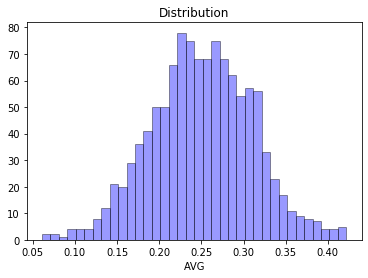

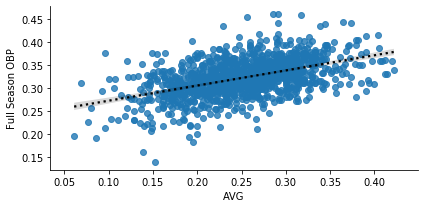

<Figure size 432x288 with 0 Axes>

In [14]:
hist(df['AVG'])
lmplot('AVG', df)
plt.savefig('AVG');

Data appears to be normally distributed with a degree of correlation to full season on-base percentage. This feature will be used in our assumption model.

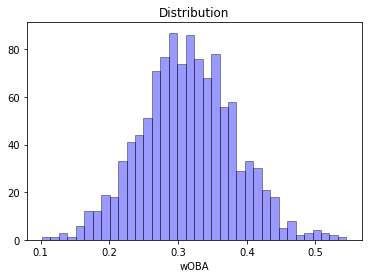

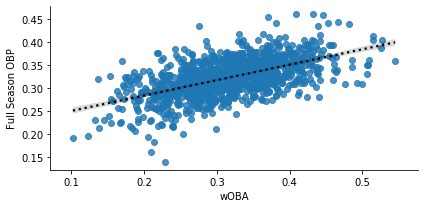

<Figure size 432x288 with 0 Axes>

In [15]:
hist(df['wOBA'])
lmplot('wOBA', df)
plt.savefig('wOBA');

Data appears to be normally distributed with a degree of correlation to full season on-base percentage. This feature will be used in our assumption model.

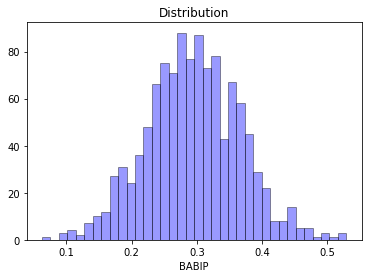

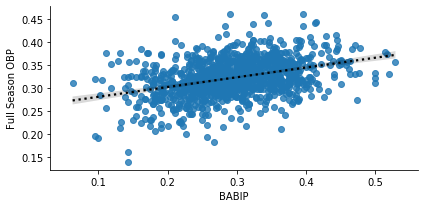

<Figure size 432x288 with 0 Axes>

In [16]:
hist(df['BABIP'])
lmplot('BABIP', df)
plt.savefig('BABIP');

Data appears to be normally distributed with a degree of correlation to full season on-base percentage. This feature will be used in our assumption model.

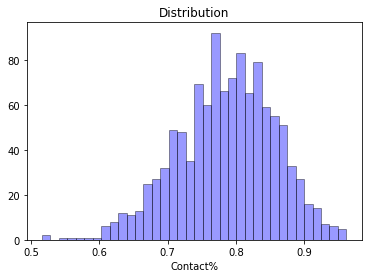

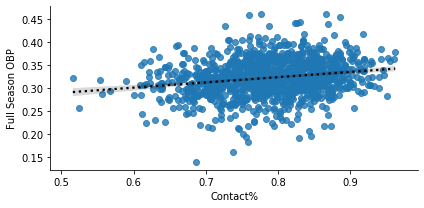

<Figure size 432x288 with 0 Axes>

In [17]:
hist(df['Contact%'])
lmplot('Contact%', df)
plt.savefig('Contact%');

Data appears to be normally distributed; however, does not appear to have much correlation to full season on-base percentage. This feature will not be used in our assumption model.

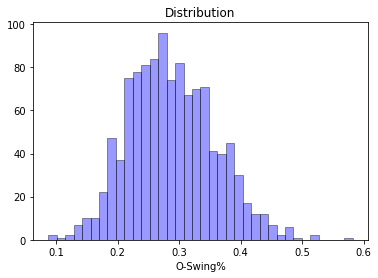

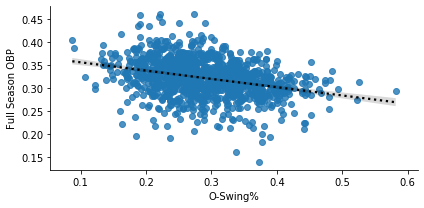

<Figure size 432x288 with 0 Axes>

In [18]:
hist(df['O-Swing%'])
lmplot('O-Swing%', df)
plt.savefig('O-Swing%');

Data appears to be normally distributed with a degree of correlation to full season on-base percentage. This feature will be used in our assumption model.

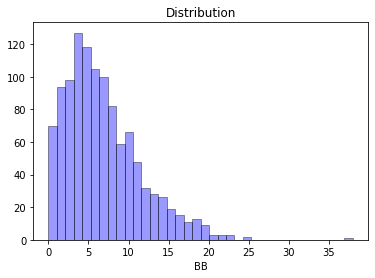

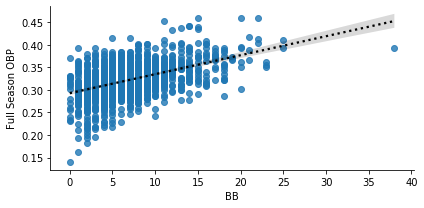

<Figure size 432x288 with 0 Axes>

In [19]:
hist(df['BB'])
lmplot('BB', df)
plt.savefig('BB');

Data does not appear to be normally distributed. This feature will not be used in our assumption model.

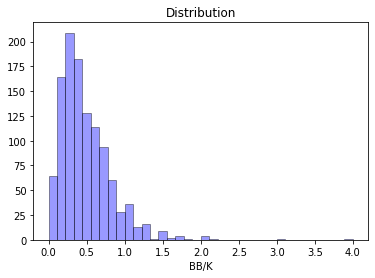

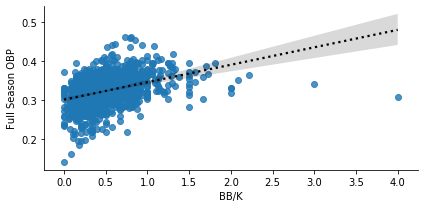

<Figure size 432x288 with 0 Axes>

In [20]:
hist(df['BB/K'])
lmplot('BB/K', df)
plt.savefig('BB_K');

Data appears to be normally distributed with a degree of correlation to full season on-base percentage. This feature will be used in our assumption model.

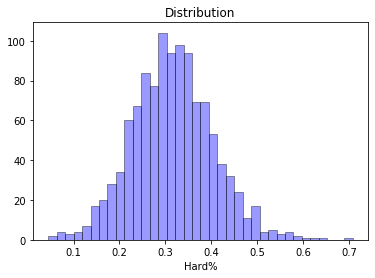

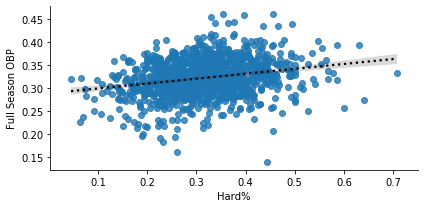

<Figure size 432x288 with 0 Axes>

In [21]:
hist(df['Hard%'])
lmplot('Hard%', df)
plt.savefig('Hard%');

Data appears to be normally distributed with a degree of correlation to full season on-base percentage. This feature will be used in our assumption model.

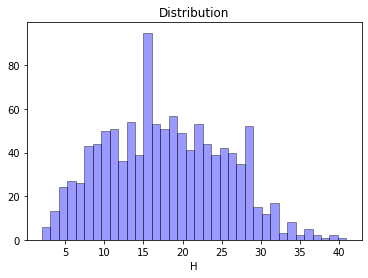

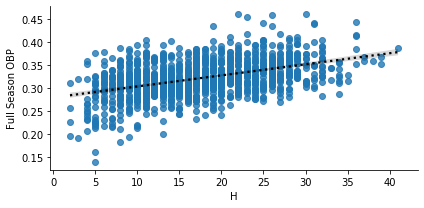

<Figure size 432x288 with 0 Axes>

In [22]:
hist(df['H'])
lmplot('H', df)
plt.savefig('H');

Data appears to be normally distributed with a degree of correlation to full season on-base percentage. This feature will be used in our assumption model.

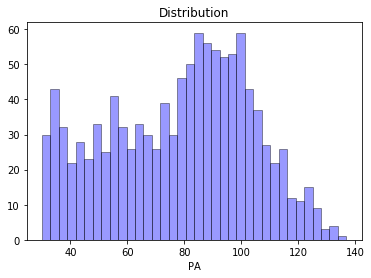

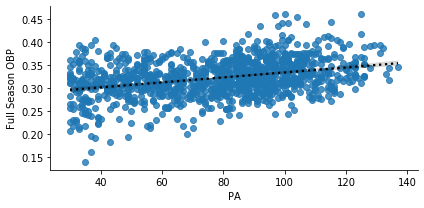

<Figure size 432x288 with 0 Axes>

In [23]:
hist(df['PA'])
lmplot('PA', df)
plt.savefig('PA');

Data does not appear to be normally distributed. This feature will not be used in our assumption model.

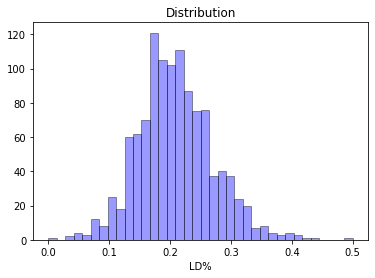

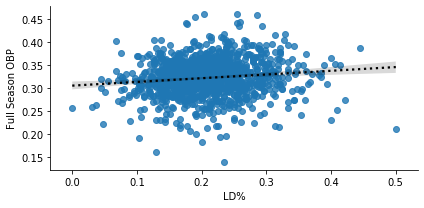

<Figure size 432x288 with 0 Axes>

In [24]:
hist(df['LD%'])
lmplot('LD%', df)
plt.savefig('LD%');

Data appears to be normally distributed with a degree of correlation to full season on-base percentage. This feature will be used in our assumption model.

In [25]:
#Create a new dataframe with target variable and features to be used in assumption model.
assumption_model = df[['Full Season OBP', 'AVG', 'BABIP', 'Hard%', 'BB/K', 
                            'O-Swing%', 'LD%', 'H', 'wOBA']]

Now I will create a linear regression model. Due to the size of the dataframe, I believe a test size of .3 will be adequate in this example. The most important value to be analyzed in the summary analysis is the r-squared value. We will use this as a base to judge future models for improvements.

In [26]:
X_m = assumption_model.drop(['Full Season OBP'], axis=1)
y_m = assumption_model['Full Season OBP']

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_m, y_m, test_size=0.3, random_state=42)

from sklearn.linear_model import LinearRegression
linreg = LinearRegression()
linreg.fit(X_train, y_train)

y_hat_train = linreg.predict(X_train)
y_hat_test = linreg.predict(X_test)

train_residuals = y_hat_train - y_train
test_residuals = y_hat_test - y_test

from sklearn.metrics import mean_squared_error

train_mse = mean_squared_error(y_train, y_hat_train)
test_mse = mean_squared_error(y_test, y_hat_test)
print('Train Mean Squarred Error:', train_mse)
print('Test Mean Squarred Error:', test_mse)

Train Mean Squarred Error: 0.0009334653430579078
Test Mean Squarred Error: 0.0009831004056582166


const       0.263050
AVG        -0.009006
BABIP       0.066057
Hard%       0.026706
BB/K        0.017740
O-Swing%   -0.144251
LD%        -0.037068
H           0.001385
wOBA        0.154309
dtype: float64
                            OLS Regression Results                            
Dep. Variable:        Full Season OBP   R-squared:                       0.444
Model:                            OLS   Adj. R-squared:                  0.438
Method:                 Least Squares   F-statistic:                     78.10
Date:                Sun, 10 Oct 2021   Prob (F-statistic):           1.62e-94
Time:                        22:03:10   Log-Likelihood:                 1638.9
No. Observations:                 792   AIC:                            -3260.
Df Residuals:                     783   BIC:                            -3218.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
      

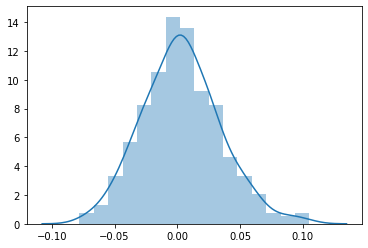

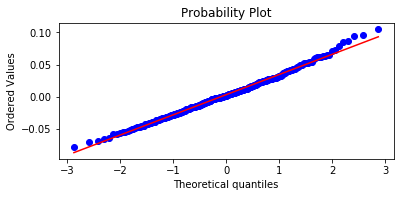

Residuals (Mean):  0.003186868579954126
Display the Regplot


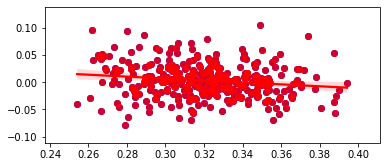

In [27]:
validate_reg_assumptions(X_m, X_train, X_test, y_train, y_test)
plt.savefig('Assumption');

The data is fairly normally distributed and has an R-Squared value of .444. All future models will be compared to this base model to determine if improvements have been made as a result of our tuning.

## Tuning Our Model

In order to tune our model for better performance we will use the stepwise function created earlier. This function utilizes p-value to determine statistical signficance and returns a suggested list of features based on that.

In [28]:
model_data = df

In [29]:
x = model_data
X = x.drop(['Full Season OBP'], axis=1)
y = x['Full Season OBP']

result = stepwise_selection(X, y, verbose=True)
print('resulting features:')
print(result)

Add  OBP                            with p-value 2.78806e-115
Add  Previous Season OBP            with p-value 1.99768e-41
Add  PA                             with p-value 9.92091e-08
Add  O-Swing%                       with p-value 2.20175e-06
Add  OPS                            with p-value 0.00232459
Add  wRC+                           with p-value 0.000154264
Add  CSW%                           with p-value 0.00421259
resulting features:
['OBP', 'Previous Season OBP', 'PA', 'O-Swing%', 'OPS', 'wRC+', 'CSW%']


In [30]:
X = x[['OBP', 'Previous Season OBP', 'PA', 'O-Swing%', 'CSW%', 'OPS', 'wRC+']]

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

from sklearn.linear_model import LinearRegression
linreg = LinearRegression()
linreg.fit(X_train, y_train)

y_hat_train = linreg.predict(X_train)
y_hat_test = linreg.predict(X_test)

train_residuals = y_hat_train - y_train
test_residuals = y_hat_test - y_test

from sklearn.metrics import mean_squared_error

train_mse = mean_squared_error(y_train, y_hat_train)
test_mse = mean_squared_error(y_test, y_hat_test)
print('Train Mean Squarred Error:', train_mse)
print('Test Mean Squarred Error:', test_mse)

Train Mean Squarred Error: 0.0008114357850858452
Test Mean Squarred Error: 0.0008281513230659969


const                  0.101778
OBP                    0.278273
Previous Season OBP    0.254718
PA                     0.000229
O-Swing%              -0.104889
CSW%                  -0.059476
OPS                    0.191405
wRC+                  -0.000669
dtype: float64
                            OLS Regression Results                            
Dep. Variable:        Full Season OBP   R-squared:                       0.517
Model:                            OLS   Adj. R-squared:                  0.512
Method:                 Least Squares   F-statistic:                     119.6
Date:                Sun, 10 Oct 2021   Prob (F-statistic):          3.40e-119
Time:                        22:03:12   Log-Likelihood:                 1694.4
No. Observations:                 792   AIC:                            -3373.
Df Residuals:                     784   BIC:                            -3335.
Df Model:                           7                                         
Covariance Type:  

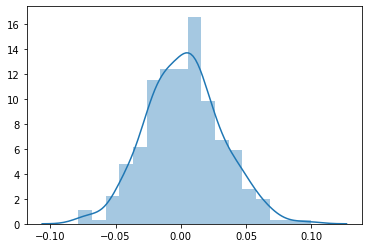

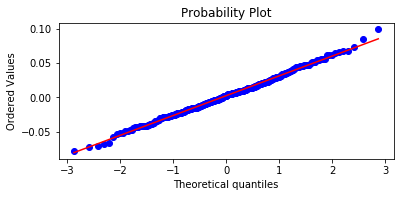

Residuals (Mean):  0.0023223780625077624
Display the Regplot


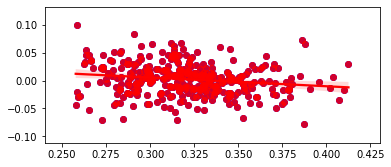

In [31]:
validate_reg_assumptions(X, X_train, X_test, y_train, y_test)

Our r-squared value has increased quite significantly from .444 to .517. Although, tuning our initial model has produced better results than the assumption model it may still be possible to increase that value. Our model has relatively low skewness, but I want to log transform the features to determine if this can't improve our results further.

In [32]:
#Create new dataframe containing features to be transformed.
log_features = model_data.columns
#Utilize the function outlined above to log transform features and append to our current dataframe.
log_transform(model_data,log_features)

,G,AB,PA,H,1B,2B,3B,HR,R,RBI,...,BUH_log,BUH%_log,Pull%_log,Cent%_log,Oppo%_log,Soft%_log,Med%_log,Hard%_log,Previous Season OBP_log,G_zscore_log
2,21,65,79,15,14,1,0,0,6,9,...,-inf,-inf,-0.898942,-0.986177,-1.514128,-1.682009,-0.551648,-1.439695,-0.894040,-0.845628
3,17,54,57,15,12,2,0,1,5,4,...,-inf,-inf,-1.328025,-0.946750,-1.058430,-1.814005,-0.560366,-1.328025,-1.087672,-1.771761
4,18,68,74,11,5,5,1,0,5,7,...,-inf,-inf,-1.099613,-0.652005,-1.924149,-1.789761,-0.504181,-1.474033,-1.200645,-3.901922
5,21,83,90,17,11,3,1,2,10,2,...,-inf,-inf,-0.865122,-0.999672,-1.555897,-1.555897,-0.642454,-1.335601,-0.946750,-0.845628
6,19,73,78,15,9,5,0,1,6,7,...,-inf,-inf,-1.002393,-1.148854,-1.148854,-1.609438,-0.567396,-1.456717,-1.142564,-2.043093
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1737,29,108,129,28,19,8,0,1,11,12,...,-inf,-inf,-0.858022,-1.227583,-1.262308,-1.629641,-0.693147,-1.190728,-1.044124,0.487309
1738,26,95,114,23,13,7,2,1,17,15,...,-inf,-inf,-0.814186,-1.374366,-1.190728,-1.731606,-0.478036,-1.594549,-1.044124,0.164190
1745,26,108,115,31,20,8,1,2,13,13,...,0.0,0.0,-0.717440,-1.335601,-1.386294,-1.814005,-0.644357,-1.161552,-1.164752,0.164190
1747,16,29,37,9,6,1,0,2,4,4,...,-inf,-inf,-0.898942,-1.505078,-0.994252,-1.687399,-0.731888,-1.099613,-1.155183,-1.139861


In [33]:
#Find where log transforming features has produce inf results and drop those columns from our dataframe.
model_data.index[np.isinf(model_data).any(1)]
model_data.columns.to_series()[np.isinf(model_data).any()]

1B_log          1B_log
2B_log          2B_log
3B_log          3B_log
HR_log          HR_log
R_log            R_log
RBI_log        RBI_log
BB_log          BB_log
IBB_log        IBB_log
SO_log          SO_log
HBP_log        HBP_log
SF_log          SF_log
SH_log          SH_log
GDP_log        GDP_log
SB_log          SB_log
CS_log          CS_log
BB%_log        BB%_log
K%_log          K%_log
BB/K_log      BB/K_log
ISO_log        ISO_log
UBR_log        UBR_log
LD%_log        LD%_log
IFFB%_log    IFFB%_log
HR/FB_log    HR/FB_log
IFH_log        IFH_log
IFH%_log      IFH%_log
BUH_log        BUH_log
BUH%_log      BUH%_log
dtype: object

In [34]:
#Drop columns containing inf values. We are dropping columns rather than rows to avoid losing any more data.
model_data = model_data.drop(['1B_log', '2B_log', '3B_log', 'HR_log', 'R_log', 'RBI_log', 'IBB_log', 'BB_log', 'SO_log', 'HBP_log', 
                              'SF_log', 'SH_log', 'GDP_log', 'SB_log', 'CS_log', 'BB%_log', 'K%_log', 'BB/K_log',
                              'ISO_log', 'UBR_log', 'LD%_log', 'IFFB%_log', 'HR/FB_log', 'IFH_log', 'IFH%_log', 
                              'BUH_log', 'BUH%_log',], axis=1)

In [37]:
model_data = model_data.fillna(0)

In [38]:
#Use stepwise feature to determine features in this model.
x = model_data
X = x.drop(['Full Season OBP', 'Full Season OBP_log'], axis=1)
y = x['Full Season OBP']

result = stepwise_selection(X, y, verbose=True)
print('resulting features:')
print(result)

Add  OBP                            with p-value 2.78806e-115
Add  Previous Season OBP            with p-value 1.99768e-41
Add  PA                             with p-value 9.92091e-08
Add  O-Swing%                       with p-value 2.20175e-06
Add  Previous Season OBP_log        with p-value 0.000170844
Add  SLG_log                        with p-value 0.00036057
Add  CSW%                           with p-value 0.0017821
Add  wRC+                           with p-value 0.00498755
resulting features:
['OBP', 'Previous Season OBP', 'PA', 'O-Swing%', 'Previous Season OBP_log', 'SLG_log', 'CSW%', 'wRC+']


In [ ]:
X = x[['OBP', 'Previous Season OBP', 'PA', 'O-Swing%', 'SLG_log', 'CSW%', 'wRC+']]

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

from sklearn.linear_model import LinearRegression
linreg = LinearRegression()
linreg.fit(X_train, y_train)

y_hat_train = linreg.predict(X_train)
y_hat_test = linreg.predict(X_test)

train_residuals = y_hat_train - y_train
test_residuals = y_hat_test - y_test

from sklearn.metrics import mean_squared_error

train_mse = mean_squared_error(y_train, y_hat_train)
test_mse = mean_squared_error(y_test, y_hat_test)
print('Train Mean Squarred Error:', train_mse)
print('Test Mean Squarred Error:', test_mse)

const                  0.101778
OBP                    0.278273
Previous Season OBP    0.254718
PA                     0.000229
O-Swing%              -0.104889
CSW%                  -0.059476
OPS                    0.191405
wRC+                  -0.000669
dtype: float64
                            OLS Regression Results                            
Dep. Variable:        Full Season OBP   R-squared:                       0.517
Model:                            OLS   Adj. R-squared:                  0.512
Method:                 Least Squares   F-statistic:                     119.6
Date:                Sun, 10 Oct 2021   Prob (F-statistic):          3.40e-119
Time:                        22:04:57   Log-Likelihood:                 1694.4
No. Observations:                 792   AIC:                            -3373.
Df Residuals:                     784   BIC:                            -3335.
Df Model:                           7                                         
Covariance Type:  

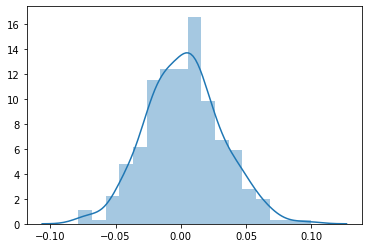

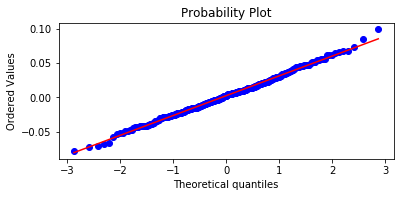

Residuals (Mean):  0.0023223780625077624
Display the Regplot


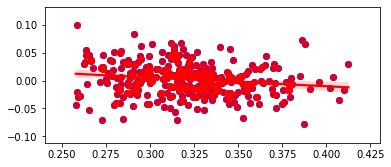

In [39]:
validate_reg_assumptions(X, X_train, X_test, y_train, y_test)

Transforming our features did not help the r-squared value. We are going to utilize our second model to create a prediction for the 2019 full season on-base percentage. I will include a future work section to make further recommendations for model tuning.

## Predicting On-Base Percentage for 2019 Season 

I utilized the list of players initially provided to make the following predictions. Additionally, I have sourced the additional data fields from fangraphs.com. I will clean the data in the same manner as I did above; however, I will not remove any outliers as I want to compare results for all players listed. One last aspect to consider is that rookies will be removed from this list as previous season on-base percentage will be utilized in the regression model.

In [40]:
#Load data from March/April of 2019
df1 = pd.read_csv('batting.csv')

In [41]:
#Identify the columns with null values
df1.isna().sum()

Name2019                    0
Team2019                    0
Year2019                    0
G2019                       0
AB2019                      0
                           ..
Soft%2019                   0
Med%2019                    0
Hard%2019                   0
Previous Season OBP2019    60
playerid2019                0
Length: 64, dtype: int64

In [42]:
#Drop values where previous season on-base percentage is null.
df1 = df1.dropna(subset=['Previous Season OBP2019'])

In [43]:
#Drop unnecessary columns
prediction_data = df1.drop(columns=['Name2019', 'Team2019', 'playerid2019'], axis=1)

In [44]:
#log_features_2019 = prediction_data.columns
#log_transform(df1,log_features_2019)

In [45]:
#Create a dataframe containing the features identified in our second model.
X1 = df1[['OBP2019', 'Previous Season OBP2019', 'PA2019', 'O-Swing%2019', 'CSW%2019', 'OPS2019', 'wRC+2019']]

In [46]:
#Create a dataframe containing the on-base percentage predictions
predictions = linreg.predict(X1)

In [47]:
#Prview the predictions dataframe
predictions

array([0.27223671, 0.31630215, 0.32337053, 0.34929448, 0.35032624,
       0.35321015, 0.37908889, 0.35823136, 0.33292573, 0.28791388,
       0.29706876, 0.38199772, 0.33177906, 0.3292658 , 0.38989892,
       0.31902123, 0.333549  , 0.30559917, 0.33003023, 0.29933834,
       0.26827652, 0.36217286, 0.32651052, 0.33463792, 0.34585345,
       0.3463791 , 0.36518886, 0.32492391, 0.35965937, 0.37884394,
       0.32606024, 0.32797988, 0.34379033, 0.34399001, 0.33879975,
       0.32182694, 0.37326351, 0.32777456, 0.37035981, 0.37065704,
       0.34527371, 0.31105292, 0.30789794, 0.38811827, 0.31652285,
       0.28703409, 0.36027626, 0.36107286, 0.27920091, 0.29846753,
       0.27935409, 0.2962258 , 0.32244359, 0.31714289, 0.37524262,
       0.34440852, 0.34975591, 0.37766574, 0.28409335, 0.34167126,
       0.30615802, 0.3187859 , 0.2679357 , 0.30758124, 0.29120414,
       0.31198912, 0.35987889, 0.3125842 , 0.34146813, 0.32353658,
       0.31282497, 0.35445134, 0.31696247, 0.34112188, 0.33029

In [48]:
#Merge the prediction values with the 2019 season stats dataframe
predictions = pd.Series(predictions)
df1 = df1.merge(predictions.to_frame(), left_index=True, right_index=True)
df1.head()

,Name2019,Team2019,Year2019,G2019,AB2019,PA2019,H2019,1B2019,2B2019,3B2019,...,BUH%2019,Pull%2019,Cent%2019,Oppo%2019,Soft%2019,Med%2019,Hard%2019,Previous Season OBP2019,playerid2019,0
0,Todd Frazier,NYM,2019,8,29,30,6,4,0,0,...,0.0,0.579,0.316,0.105,0.053,0.632,0.316,0.303,785,0.272237
1,Albert Pujols,LAA,2019,27,91,107,20,12,4,0,...,0.0,0.557,0.304,0.139,0.241,0.354,0.405,0.289,1177,0.316302
2,Wilson Ramos,NYM,2019,28,89,99,22,19,2,0,...,0.0,0.347,0.347,0.307,0.187,0.453,0.360,0.358,1433,0.323371
3,Miguel Cabrera,DET,2019,27,103,117,29,23,5,0,...,0.0,0.384,0.370,0.247,0.096,0.370,0.534,0.395,1744,0.349294
4,David Peralta,ARI,2019,29,123,132,39,21,13,1,...,0.0,0.380,0.370,0.250,0.163,0.337,0.500,0.352,2136,0.350326


In [49]:
#Rename the new column to Predicted OBP
df1 = df1.rename(columns = {0:'Predicted OBP'})

In [50]:
#Find the variance between the actual 2019 full season on-base percentage and the predicted on-base percentage
df1['OBP_Variance'] = round(df1['Full Season OBP2019'] - df1['Predicted OBP'], 4)

In [51]:
df1

,Name2019,Team2019,Year2019,G2019,AB2019,PA2019,H2019,1B2019,2B2019,3B2019,...,Pull%2019,Cent%2019,Oppo%2019,Soft%2019,Med%2019,Hard%2019,Previous Season OBP2019,playerid2019,Predicted OBP,OBP_Variance
0,Todd Frazier,NYM,2019,8,29,30,6,4,0,0,...,0.579,0.316,0.105,0.053,0.632,0.316,0.303,785,0.272237,0.0568
1,Albert Pujols,LAA,2019,27,91,107,20,12,4,0,...,0.557,0.304,0.139,0.241,0.354,0.405,0.289,1177,0.316302,-0.0113
2,Wilson Ramos,NYM,2019,28,89,99,22,19,2,0,...,0.347,0.347,0.307,0.187,0.453,0.360,0.358,1433,0.323371,0.0276
3,Miguel Cabrera,DET,2019,27,103,117,29,23,5,0,...,0.384,0.370,0.247,0.096,0.370,0.534,0.395,1744,0.349294,-0.0033
4,David Peralta,ARI,2019,29,123,132,39,21,13,1,...,0.380,0.370,0.250,0.163,0.337,0.500,0.352,2136,0.350326,-0.0073
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
254,Mike Tauchman,NYY,2019,22,62,71,11,4,4,0,...,0.415,0.293,0.293,0.146,0.512,0.341,0.194,15274,0.335120,0.0259
256,Kris Bryant,CHC,2019,26,100,121,23,10,10,0,...,0.468,0.215,0.316,0.114,0.494,0.392,0.374,15429,0.377818,0.0042
257,Ryon Healy,SEA,2019,32,116,130,27,9,13,0,...,0.511,0.217,0.272,0.163,0.467,0.370,0.277,15447,0.302311,-0.0133
258,Hunter Renfroe,SDP,2019,26,75,82,18,6,5,1,...,0.614,0.316,0.070,0.158,0.351,0.491,0.302,15464,0.321785,-0.0328


In [52]:
#Create new dataframe containing: Name, Full Season OBP, Predicted OBP and OBP Variance
OBP_vs_Predicted = df1[['Name2019', 'Full Season OBP2019', 'Predicted OBP', 'OBP_Variance']]
OBP_vs_Predicted.head(20)

,Name2019,Full Season OBP2019,Predicted OBP,OBP_Variance
0,Todd Frazier,0.329,0.272237,0.0568
1,Albert Pujols,0.305,0.316302,-0.0113
2,Wilson Ramos,0.351,0.323371,0.0276
3,Miguel Cabrera,0.346,0.349294,-0.0033
4,David Peralta,0.343,0.350326,-0.0073
5,Edwin Encarnacion,0.344,0.353210,-0.0092
6,Carlos Santana,0.397,0.379089,0.0179
7,Nelson Cruz,0.392,0.358231,0.0338
8,Yonder Alonso,0.296,0.332926,-0.0369
9,Manny Pina,0.313,0.287914,0.0251


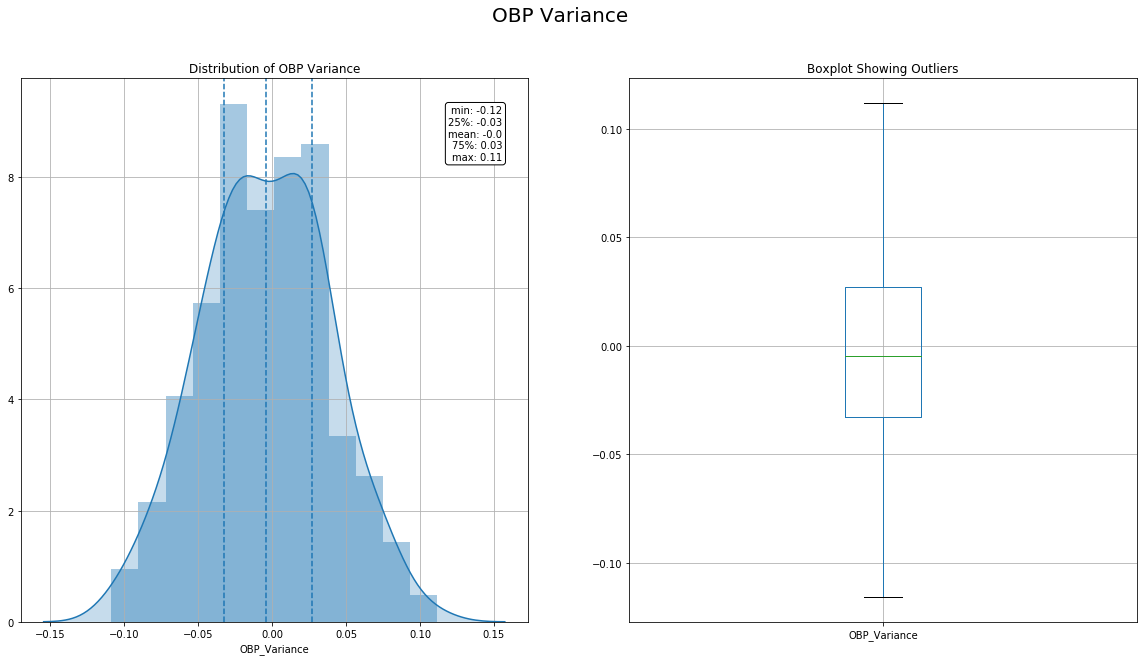

In [53]:
# Create two graphs, a Distribution and Boxplot visualizing OBP_Variance across all batters.
fig, ax = plt.subplots(nrows=1, ncols=2,  sharex=False, sharey=False, figsize=(20,10))
fig.suptitle('OBP Variance', fontsize=20)

# Create Distribution Showing OBP_Variance
ax[0].title.set_text('Distribution of OBP Variance')
variable = OBP_vs_Predicted['OBP_Variance']
breaks = np.quantile(variable, q=np.linspace(0, 1, 11))
variable = variable[ (variable > breaks[0]) & (variable < 
                    breaks[10]) ]
sns.distplot(variable, hist=True, kde=True, kde_kws={"shade": True}, ax=ax[0])
des = OBP_vs_Predicted['OBP_Variance'].describe()
ax[0].axvline(des["25%"], ls='--')
ax[0].axvline(des["mean"], ls='--')
ax[0].axvline(des["75%"], ls='--')
ax[0].grid(True)
des = round(des, 2).apply(lambda x: str(x))
box = '\n'.join(("min: "+des["min"], "25%: "+des["25%"], "mean: "+des["mean"], "75%: "+des["75%"], "max: "+des["max"]))
ax[0].text(0.95, 0.95, box, transform=ax[0].transAxes, fontsize=10, va='top', ha="right", bbox=dict(boxstyle='round', facecolor='white', alpha=1))

# Create a Boxplot showing Outliers.
ax[1].title.set_text('Boxplot Showing Outliers')
OBP_vs_Predicted.boxplot(column='OBP_Variance', ax=ax[1])
plt.show()

## Summary

As a whole this model does not perform as well as desired. There are several considerations to be made to improve the results in the future. With that in mind, 50% of the player's predicted on-base percentage falls within .06 of the actual results. Another positive is that the tuning of our model was able to more accurately predict the results than our assumption model as seen in an increase in r-square value. An additional success is that the model is fully reproducible and with additional tuning can become an incredibly useful tool season after season. Finally, adding the stats from May when they become available could result in a more accurate prediction and has the capability be adjusted on a month-by-month basis.

## Future Work

1. Feature Engineering - Are there any additional features that can be created to add value?
2. Address Multicollinearity - Which features are highly correlated?
3. Modifying Dataset - Would increasing or decreasing the number of seasons in the dataset improve results?
4. Create Prediction Model for Rookies - Utilize stats from AA/AAA to create model that satisfies need expressed above.